# **텐서플로우 모델 생성 (sine 모델)**
sine 함수로 생성된 데이터를 모델링하기 위해 신경망 모델을 훈련한다. 원하는 신경망 모델을 만든 후 마이크로 컨트롤러에서 사용할 수 있는 TensorFlow Lite 바이너리를 만들 것이다.

**이 노트북은 "초소형 머신러닝 TinyML"의 예제 코드 기반으로 직접 실습하면서 과정을 정리한다.**

# 종속성 로드 및 라이브러리 추가

## 종속성 로드
필요한 종속성을 로드한다.

In [ ]:
# 텐서플로우 설치
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 52.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

## 라이브러리 추가
작업에 사용할 라이브러리를 추가한다.
이름이 긴 라이브러리는 나중에 쉽게 참조하기 위해 별칭을 부여한다.

별칭을 부여할 때는 "import 라이브러리 as 별칭"으로 작성한다.

In [ ]:
# 사용할 라이브러리를 추가한다.
# 텐서플로우 라이브러리 추가
import tensorflow as tf
# 넘파이 라이브러리 추가
import numpy as np
# 그래프 라이브러리 추가
import matplotlib.pyplot as plt
# 수학 라이브러리 추가
import math

# 데이터 생성

딥러닝 네트워크는 데이터에서 패턴을 학습한다. sine 함수로 생성된 데이터를 모델링하기 위해 네트워크를 훈련한다.

아래 코드는 임의의 x 값으로 세트를 생성하고 sine 값을 계산하여 그래프로 표시한다.

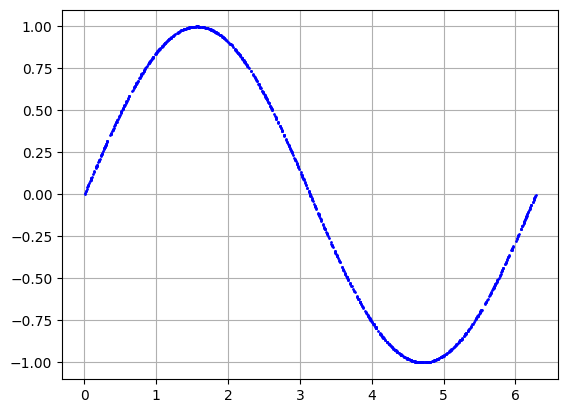

In [ ]:
# 생성할 샘플 데이터 수를 설정한다.
SAMPLES = 1000

# 시드값을 지정한다(어떤 숫자든 사용할 수 있다).
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# sine 진폭의 범위인 0 ~ 2π 내에서 균일하게 분포된 난수 집합을 생성한다.
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# 생성된 값을 무작위로 섞어서 순서를 따르지 않도록 한다.
np.random.shuffle(x_values)

# 생성된 값에 해당하는 sine 값을 계산한다.
y_values = np.sin(x_values)

# 데이터를 그래프로 표시한다.
# 'b.' 인수는 점을 파란색으로 출력하도록 한다.
plt.grid(True)
plt.plot(x_values, y_values, 'b.', markersize=2)
plt.show()


# 생성 데이터에 노이즈 추가

sine 함수에 의해 직접 생성된 데이터는 부드러운 곡선을 따라 생성된 점의 집합이다. 이를 직접 사용하여 모델을 학습시킬 수 있다.

하지만 딥러닝 네트워크의 흥미로운 점 중 하나는 잡음 속에서 패턴을 선별하는 기능이다. 이를 위해 데이터에 약간의 노이즈를 추가하여 실세계 데이터와 비슷하게 만든다.

아래 코드는 sine 함수의 출력 값에 임의의 노이즈를 추가하여 그래프로 표시한다.

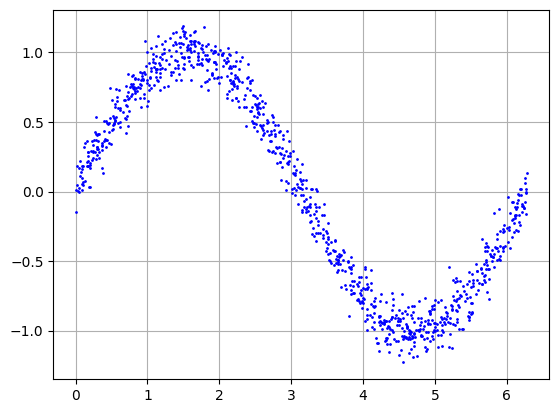

In [ ]:
# 각 y 값에 임의의 작은 숫자를 추가한다.
y_values += 0.1 * np.random.randn(*y_values.shape)

# 노이즈가 추가된 데이터를 그래프에 표시한다.
plt.grid(True)
plt.plot(x_values, y_values, 'b.', markersize=2)
plt.show()

# 데이터 분할

실세계 데이터와 비슷한 노이즈가 추가된 데이터 세트를 앞에서 생성하였다. 모델을 훈련시키기 위해 이 데이터를 사용할 것이다.

훈련시키는 모델의 정확성을 평가하려면 예측 데이터와 실제 데이터를 비교하여 어느정도 일치하는지 확인해야 한다. 이러한 평가는 훈련중(검증)과 훈련후(테스트)에 실시한다. 두 경우 모두 모델 훈련에 사용되지 않은 새로운 데이터를 사용해야 한다.

생성된 데이터를 모델 학습에 60%, 검증 20%, 테스트 20%의 데이터로 분할한다.

아래 코드는 데이터를 분할한 후 각각 다른 색상으로 그래프에 표시한다.

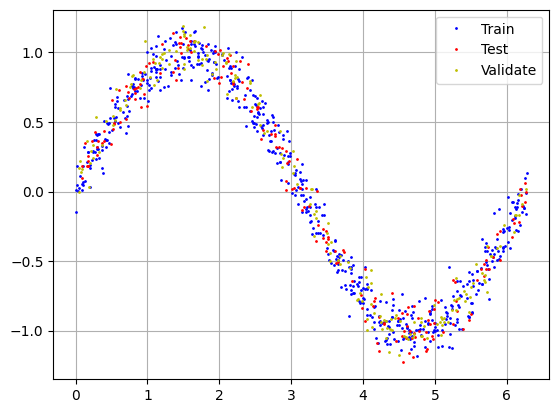

In [ ]:
# 생성된 데이터는 학습에 60%, 검증에 20%, 테스트에 20%를 사용한다.
TRAIN_RATES = 0.6
VALIDATE_RATES = 0.2
TEST_RATES = 0.2

# 각 항목의 인덱스를 계산한다.
TRAIN_SPLIT = int(TRAIN_RATES * SAMPLES)
TEST_SPLIT = int(TEST_RATES * SAMPLES + TRAIN_SPLIT)

# np.split을 사용하여 데이터를 세 부분으로 분할한다.
# np.split의 두 번째 인수는 데이터가 분할되는 인덱스 배열이다.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# 분할된 데이터 크기가 원래의 크기와 같은지 확인한다.
assert (x_train.size + x_test.size + x_validate.size) == SAMPLES
assert (y_train.size + y_test.size + y_validate.size) == SAMPLES

# 분할된 각 데이터를 그래프에 다른 색상으로 표시한다.
plt.grid(True)
plt.plot(x_train, y_train, 'b.', label="Train", markersize=2)
plt.plot(x_test, y_test, 'r.', label="Test", markersize=2)
plt.plot(x_validate, y_validate, 'y.', label="Validate", markersize=2)
plt.legend()
plt.show()

# 모델 설계

입력(x)을 받아 출력(x의 sine)을 예측하는 모델을 만든다. 이러한 유형의 문제를 회귀(regression)라 한다.

뉴런(neurons)과 레이어(layers)를 사용하는 간단한 신경망을 만들어 훈련 데이터의 기본적인 패턴을 학습하여 예측을 수행한다.

두 개의 레이어를 정의한다. 첫 번째 레이어는 단일 입력(x값)으로 16개의 뉴런을 활성화한다. 입력에 따라 각 뉴런은 내부 상태(가중치(weight)와 편향(bias))에 따라 활성화(activated)된다. 뉴런의 활성화 정도는 숫자로 표현된다.

첫 번째 레이어의 활성화 정도는 두 번째 레이어의 입력으로 사용된다. 이 입력에 자체 가중치와 편향을 적용하여 활성화 정도를 계산하여 y 값으로 출력한다.

아래 코드는 딥러닝 네트워크를 만들기위해 TensorFlow의 고수준 API인 Keras를 사용하여 모델을 정의한다. 네트워크를 정의하고 훈련 방법을 결정하는 파라미터를 지정하여 컴파일(compile)을 진행한다.

In [ ]:
# 간단한 신경망 모델을 만들기 위해 케라스를 사용한다.
from tensorflow.keras import layers

# 케라스를 사용하여 순차 모델 생성
model_1 = tf.keras.Sequential()

# 첫 번째 레이어를 추가한다.
# 첫 번째 레이어는 16개의 뉴런을 통해 스칼라(Scalar) 입력을 받아 다음 레이어에 전달한다.
# 뉴런은 활성화 함수 'relu'에 따라 값을 전달한다.
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# 두 번째 레이어를 추가한다.
# 두 번째 레이어는 원하는 출력이 하나의 값이기 때문에 하나의 뉴런이다.
model_1.add(layers.Dense(1))

# 옵티마이저와 손실 함수를 지정하여 회귀 모델을 컴파일한다.
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# 신경망 모델의 아키텍처 요약 정보를 출력한다.
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


# 모델 훈련하기

모델을 만든 후에 데이터를 사용하여 훈련(train)을 진행한다.

훈련은 신경망 모델에 x 값을 입력하여 신경망 모델의 출력이 예상되는 y 값과 얼마나 차이가 나는지 확인하고 다음 출력이 좀 더 정확할 수 있도록 뉴련의 가중치와 편향을 조정한다.

훈련은 이러한 프로세스를 전체 훈련 데이터 세트에서 여러 번 실행하는데, 이 횟수를 에포크(epoch)라고 한다. 훈련 중에 실행할 에포크 수는 설정할 수 있는 파라미터이다.

에포크 동안 데이터는 여러 배치(batches)로 신경망 모델을 통해 실행된다. 신경망 모델의 가중치와 편향은 매 배치마다 한 번씩 조정된다. 배치 사이즈(batch_size)도 설정할 수 있는 파라미터이다.

다음 코드는 학습 데이터의 x와 y 값을 사용하여 신경망 모델을 학습한다. 1000 에포크(epochs)에 배치 사이즈(batch_size)는 16이고 검증(validation)에 사용할 데이터도 설정한다.

코드 실행시 훈련을 완료하는 데 시간이 걸릴 수 있다.

In [ ]:
# 신경망 모델을 훈련한다.
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 7ms/step - loss: 0.5814 - mae: 0.6785 - val_loss: 0.5432 - val_mae: 0.6634
Epoch 2/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.4279 - mae: 0.5711 - val_loss: 0.4736 - val_mae: 0.5959
Epoch 3/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.3903 - mae: 0.5404 - val_loss: 0.4405 - val_mae: 0.5837
Epoch 4/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.3612 - mae: 0.5216 - val_loss: 0.4052 - val_mae: 0.5558
Epoch 5/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.3338 - mae: 0.5028 - val_loss: 0.3716 - val_mae: 0.5301
Epoch 6/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.3070 - mae: 0.4824 - val_loss: 0.3425 - val_mae: 0.5043
Epoch 7/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2843 - mae: 0.4637 - val_loss: 0.3239 - val_mae: 0.5031
Epoch 8/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.

# 훈련 지표 확인

훈련 과정 중에 신경망 모델의 성능은 훈련 데이터와 검증 데이터에 대해 지속적으로 측정된다.

아래 코드는 훈련 과정에서 신경망 모델의 성능이 어떻게 변했는지 데이터 로그중 일부를 그래프로 표시한 것이다.

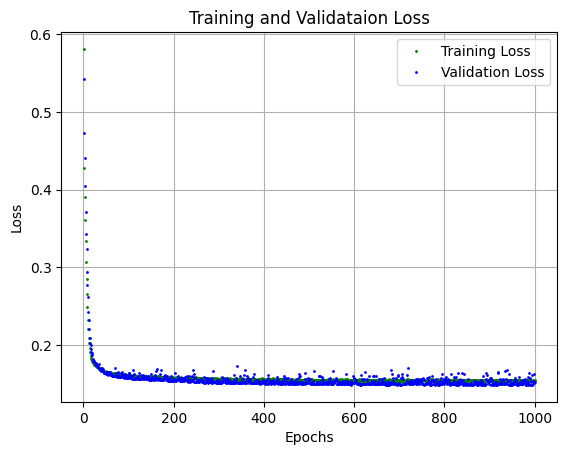

In [ ]:
# 훈련과 검증 과정에서 예측값과 실제값의 차이인 손실 그래프를 표시한다.
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.grid(True)
plt.plot(epochs, loss, 'g.', label='Training Loss', markersize=2)
plt.plot(epochs, val_loss, 'b.', label='Validation Loss', markersize=2)
plt.title('Training and Validataion Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 데이터 살펴보기

이전 그래프는 각 에포크에 대한 손실값(loss:예측과 실제 데이터의 차이)을 보여준다. 손실을 계산하는 방법에는 여러 가지가 있지만, 여기서는 평균제곱오차(mean squared error)를 사용했다. 이전 그래프에서 훈련 및 검증 데이터에 대한 손실값을 확인할 수 있다.

이전 그래프를 보면 손실값이 평평 해지기 전에 급속히 감소한다. 이는 신경망 모델이 개선되어 정확한 에측을 수행하고 있다는 것을 의미한다.

목표는 신경망 모델이 더 이상 개선되지 않거나, 훈련 손실값(training loss)이 검증 손실값(validation loss)보다 작을 때 훈련을 중단하는 것이다. 이는 신경망 모델이 더 이상 새로운 데이터로 일반화 할 수 없도록 훈련 데이터를 잘 예측하는 법을 배웠다는 것을 의미한다.

아래 코드는 평평한 부분을 보다 보기 쉽도록 급속히 감소하는 영역을 제외하고 표시한다.

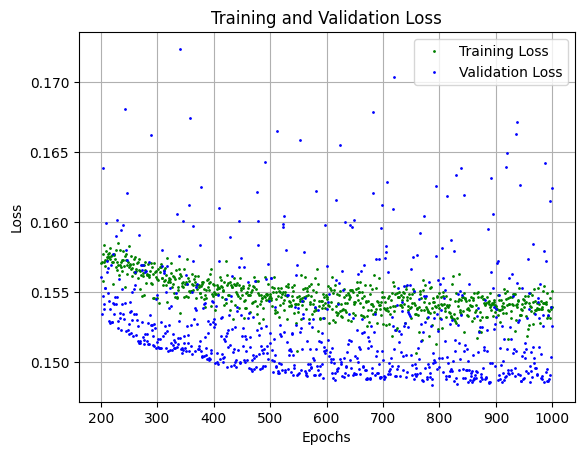

In [ ]:
# 그래프를 보기 쉽도록 처음 몇 에폭을 제외.
SKIP = 200

plt.grid(True)
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training Loss', markersize=2)
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation Loss', markersize=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 지표 활용

위의 그래프에서 약 600 에폭(사용 환경에 따라 변할 수 있음)까지 손실이 감소하고 이후부터 안정적인 움직임을 보이고 있다. 이는 600 에폭이 넘어가면 신경망 모델을 더 이상 훈련시킬 필요가 없다는 것을 의미한다.

참고로 환경에 따라 다소 차이가 날 수 있다.

신경망 모델에 대한 통찰력을 얻기 위해 더 많은 그래프를 그려볼 수 있다. 이번에는 평균절대오차를 사용해 본다. 이는 신경망 모델 예측이 실제값과 얼마나 차이가 나는지 측정하는 또 다른 방법이다.

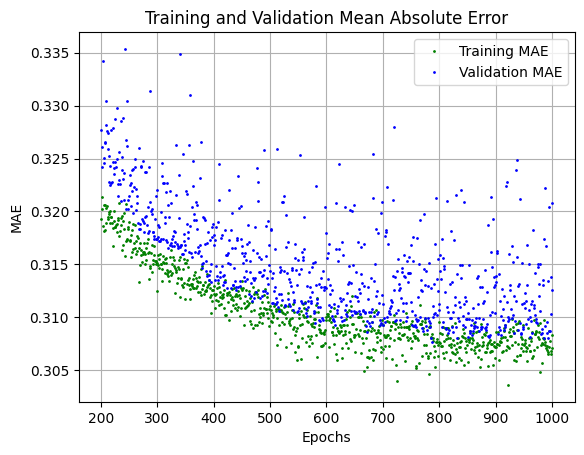

In [ ]:
plt.clf()
plt.grid(True)

# 예측에서 오차의 양을 측정하는 또 다른 방법인 평균절대오차 그래프를 그린다.
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE', markersize=2)
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE', markersize=2)
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

평균절대오차(mean absolute error) 그래프는 신경망 모델의 다른 측면을 보여준다. 훈련 데이터에 비해 검증 데이터에서 보다 일관되게 오류가 높다는 것이다. 이는 신경망 모델에 과적합(overfit)이 있거나 훈련 데이터를 너무 학습하여 새로운 데이터를 효과적으로 예측 할 수 없다는 것을 의미한다.

책에서는 오차가 30% 정도 나온 상태로 설명을 진행한다(환경에 따라 다소 차이가 날 수 있다).

현재 신경망 모델의 예측값을 그래프로 표시한다.

19/19 [==============================] - 0s 1ms/step


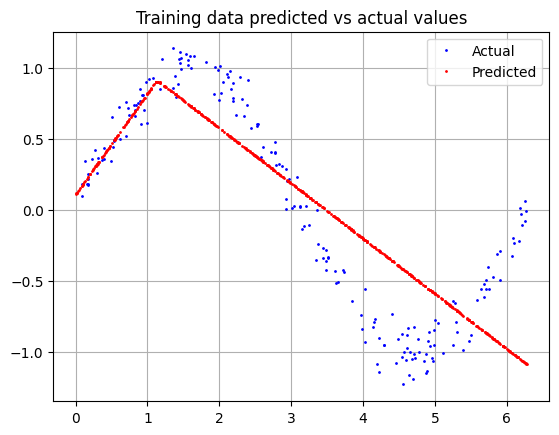

In [ ]:
# 신경망 모델을 사용하여 검증 데이터로부터 예측값을 생성한다.
predictions = model_1.predict(x_train)

# 테스트 데이터와 함께 예측값을 그래프로 표시한다.
plt.clf()
plt.grid(True)
plt.title('Training data predicted vs actual values')
plt.plot(x_test, y_test, 'b.', label='Actual', markersize=2)
plt.plot(x_train, predictions, 'r.', label='Predicted', markersize=2)
plt.legend()
plt.show()

신경망 모델을 더 크게 만들면 Capacity가 늘어나고 성능은 향상될 수 있다.

# 모델 변경

신경망 모델을 더 크게 만들기 위해 레이어를 추가한다.

다음 코드는 이전과 동일하지만 중간에 16개의 뉴런을 추가했다.

In [ ]:
# 케라스를 사용하여 순차 모델 생성
model_2 = tf.keras.Sequential()

# 첫 번째 레이어를 추가한다.
# 첫 번째 레이어는 16개의 뉴런을 통해 스칼라(Scalar) 입력을 받아 다음 레이어에 전달한다.
# 뉴런은 활성화 함수 'relu'에 따라 값을 전달한다.
model_2.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# 두 번째 레이어를 추가한다.
# 신경망 모델이 더 복잡한 표현을 배우는 데 도움을 준다.
model_2.add(layers.Dense(16, activation='relu'))

# 세 번째 레이어를 추가한다.
# 세 번째 레이어는 원하는 출력이 하나의 값이기 때문에 하나의 뉴런이다.
model_2.add(layers.Dense(1))

# 옵티마이저와 손실 함수를 지정하여 회귀 모델을 컴파일한다.
model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# 신경망 모델의 아키텍처 요약 정보를 출력한다.
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


새로운 신경망 모델을 훈련한다.

In [ ]:
# 신경망 모델을 훈련한다.
history_2 = model_2.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 10ms/step - loss: 0.3753 - mae: 0.5293 - val_loss: 0.3858 - val_mae: 0.5407
Epoch 2/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.3014 - mae: 0.4776 - val_loss: 0.3164 - val_mae: 0.4789
Epoch 3/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.2521 - mae: 0.4387 - val_loss: 0.2676 - val_mae: 0.4591
Epoch 4/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.2194 - mae: 0.4104 - val_loss: 0.2315 - val_mae: 0.4268
Epoch 5/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1986 - mae: 0.3929 - val_loss: 0.2017 - val_mae: 0.3958
Epoch 6/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1841 - mae: 0.3764 - val_loss: 0.1897 - val_mae: 0.3773
Epoch 7/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1783 - mae: 0.3674 - val_loss: 0.1894 - val_mae: 0.3825
Epoch 8/1000
38/38 [==============================] - 0s 3ms/step - loss: 0

# 새 신경망 모델 평가하기

훈련과 검증 데이터에 대한 손실 및 평균절대오차는 최종 다음과 같이 출력된다(환경마다 다를 수 있다).
[loss: 0.0119 - mae: 0.0876 - val_loss: 0.0101 - val_mae: 0.0802]

이전보다 많은 개선이 있다.

아래 코드는 새 신경망 모델에 대한 평가 그래프를 출력한다.

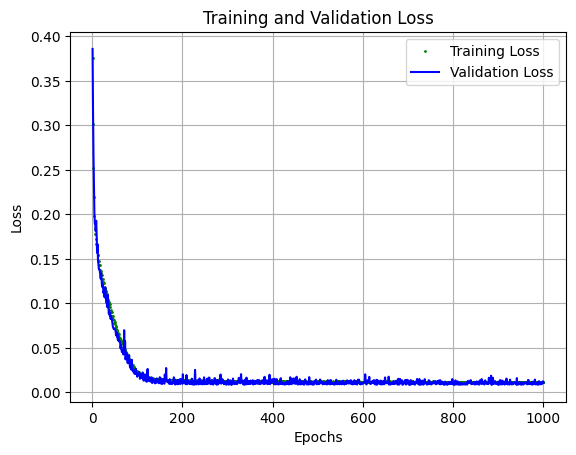

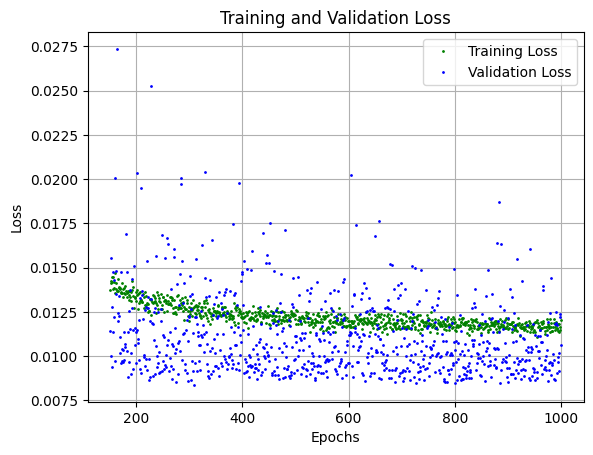

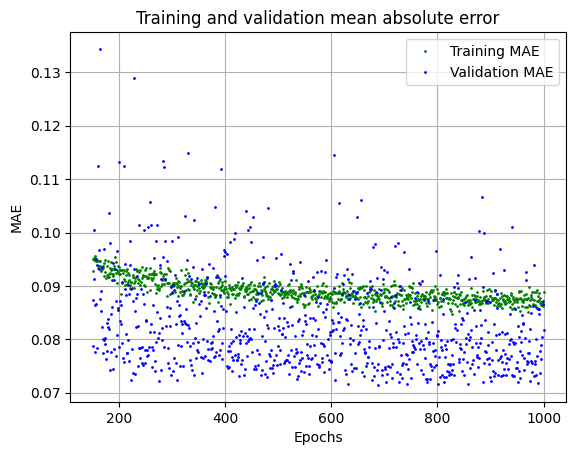

In [ ]:
# 훈련과 검증 과정에서 예측값과 실제값 사이의 거리인 손실 그래프를 그린다.
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.grid(True)
plt.plot(epochs, loss, 'g.', label='Training Loss', markersize=2)
plt.plot(epochs, val_loss, 'b', label='Validation Loss', markersize=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 그래프를 보기 쉽도록 처음 몇 에폭을 제외.
SKIP = 150

plt.clf()
plt.grid(True)

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training Loss', markersize=2)
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation Loss', markersize=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.grid(True)

# 예측에서 오차의 양을 측정하는 또 다른 방법인 평균 절대 오차 그래프를 그린다.
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE', markersize=2)
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE', markersize=2)
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

이 그래프에서 몇 가지 흥미로운 점을 찾을 수 있다.


*   새 신경망 모델은 이전 보다 빠르게 최고 정확도에 도달했다(600에서 400 에포크 이내).
*   전체 손실과 MAE는 이전 신경망 모델보다 개선되었다.
* 전체적인 지표가 훈련보다 검증 데이터에 좋다(과적합되지 않음).

검증 지표가 훈련 지표보다 좋은 이유는 검증은 각 에포크의 끝에서 계산되는 반면, 훈련은 전체 에포크에서 계산되므로 더 오래 훈련된 모델에서 검증이 발생하기 때문이다.

아래 코드는 테스트 데이터와 비교하여 예측을 확인하는 그래프를 출력한다.


7/7 [==============================] - 0s 2ms/step


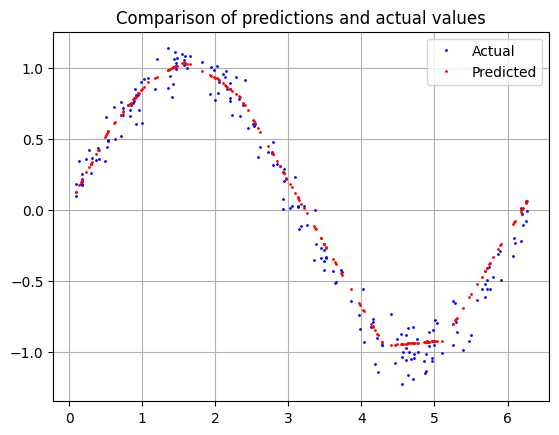

In [ ]:
# 테스트 데이터셋의 손실 계산 및 출력
loss = model_2.evaluate(x_test, y_test)

# 테스트 데이터셋 기반으로 예측을 수행한다.
predictions = model_2.predict(x_test)

# 실제값에 대한 예측 그래프
plt.clf()
plt.grid(True)
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual', markersize=2)
plt.plot(x_test, predictions, 'r.', label='Predicted', markersize=2)
plt.legend()
plt.show()

이전보다 4 ~ 5 구간의 예측이 좋아졌다(sine에 가까워짐).

출력한 평가 지표는 신경망 모델이 테스트 데이터에서 손실과 MAE가 낮고 예측이 데이터와 시각적으로 잘 일치하는 것을 보여준다.

모델이 완벽하지는 않은데, 4 ~ 5 사이에서 거의 직선에 가까운 예측을 볼 수 있다. 여기서 더 개선하려면 신경망 모델의 용량을 늘리고 추가적인 기법을 사용하여 과적합을 막을 수도 있다.


In [ ]:
# 케라스를 사용하여 순차 모델 생성
model_3 = tf.keras.Sequential()

# 첫 번째 레이어를 추가한다.
# 첫 번째 레이어는 16개의 뉴런을 통해 스칼라(Scalar) 입력을 받아 다음 레이어에 전달한다.
# 뉴런은 활성화 함수 'relu'에 따라 값을 전달한다.
model_3.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# 두 번째 레이어를 추가한다.
# 신경망 모델이 더 복잡한 표현을 배우는 데 도움을 준다.
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dense(16, activation='relu'))

# 세 번째 레이어를 추가한다.
# 세 번째 레이어는 원하는 출력이 하나의 값이기 때문에 하나의 뉴런이다.
model_3.add(layers.Dense(1))

# 옵티마이저와 손실 함수를 지정하여 회귀 모델을 컴파일한다.
model_3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# 신경망 모델의 아키텍처 요약 정보를 출력한다.
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                32        
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 신경망 모델을 훈련한다.
history_3 = model_3.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 7ms/step - loss: 0.5689 - mae: 0.6216 - val_loss: 0.4128 - val_mae: 0.5585
Epoch 2/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.3314 - mae: 0.5011 - val_loss: 0.3491 - val_mae: 0.5007
Epoch 3/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2767 - mae: 0.4577 - val_loss: 0.2921 - val_mae: 0.4763
Epoch 4/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2367 - mae: 0.4222 - val_loss: 0.2487 - val_mae: 0.4398
Epoch 5/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2085 - mae: 0.3972 - val_loss: 0.2098 - val_mae: 0.3995
Epoch 6/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1875 - mae: 0.3729 - val_loss: 0.1916 - val_mae: 0.3729
Epoch 7/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1779 - mae: 0.3582 - val_loss: 0.1910 - val_mae: 0.3760
Epoch 8/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.

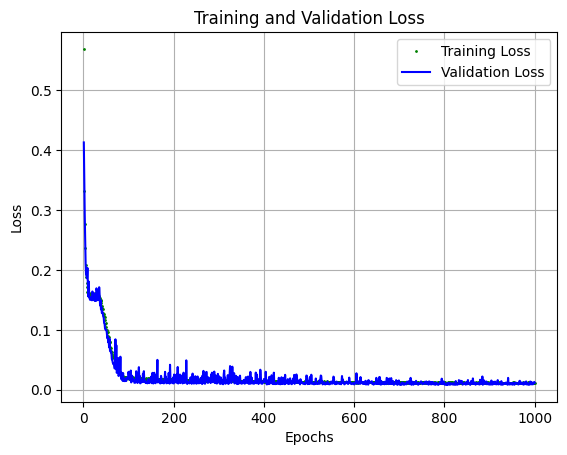

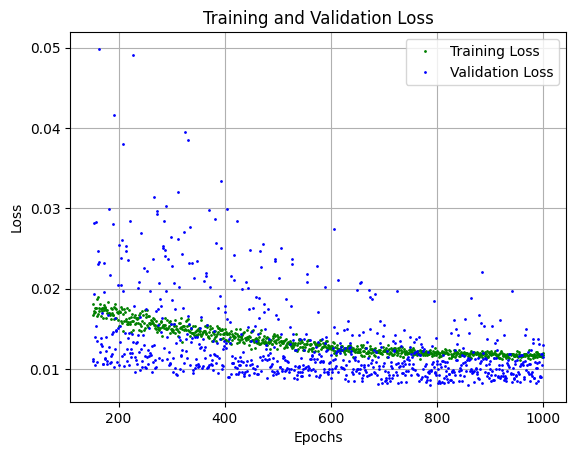

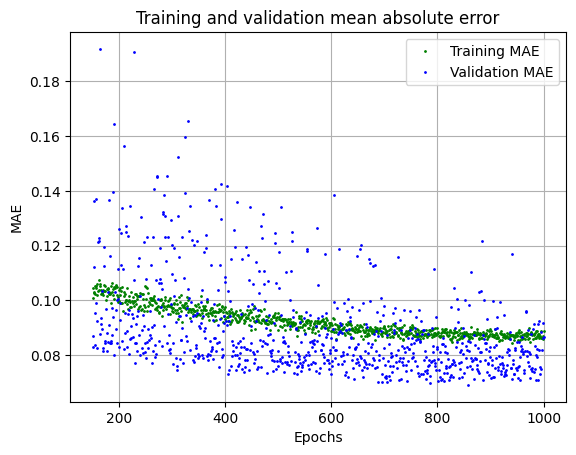

In [ ]:
# 훈련과 검증 과정에서 예측값과 실제값 사이의 거리인 손실 그래프를 그린다.
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.grid(True)
plt.plot(epochs, loss, 'g.', label='Training Loss', markersize=2)
plt.plot(epochs, val_loss, 'b', label='Validation Loss', markersize=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 그래프를 보기 쉽도록 처음 몇 에폭을 제외.
SKIP = 150

plt.clf()
plt.grid(True)

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training Loss', markersize=2)
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation Loss', markersize=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.grid(True)

# 예측에서 오차의 양을 측정하는 또 다른 방법인 평균 절대 오차 그래프를 그린다.
mae = history_3.history['mae']
val_mae = history_3.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE', markersize=2)
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE', markersize=2)
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

7/7 [==============================] - 0s 2ms/step


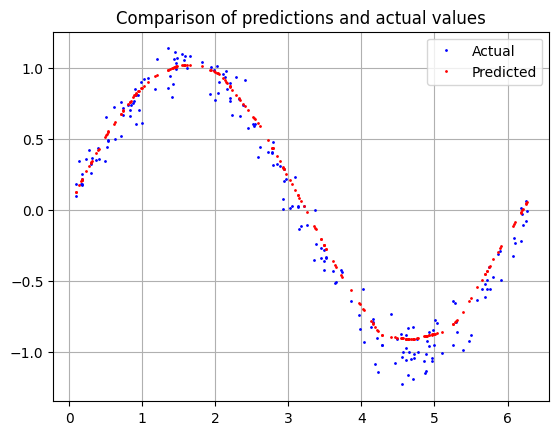

In [ ]:
# 테스트 데이터셋의 손실 계산 및 출력
loss = model_3.evaluate(x_test, y_test)

# 테스트 데이터셋 기반으로 예측을 수행한다.
predictions = model_3.predict(x_test)

# 실제값에 대한 예측 그래프
plt.clf()
plt.grid(True)
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual', markersize=2)
plt.plot(x_test, predictions, 'r.', label='Predicted', markersize=2)
plt.legend()
plt.show()

# TensorFlow Lite로 변환

지금까지의 작업으로 원하는 목표의 sine 함수에 대한 신경망 모델을 만들었다. 그러나 마이크로 컨트롤러용 TensorFlow Lite에 사용하려면 모델 형식을 변환해야 한다. TensorFlow Lite Converter는 마이크로 컨트롤러와 같이 제한된 메모리에서 사용하기 위한 특수한 형식으로 모델을 변환한다.

지금까지 작업한 신경망 모델은 마이크로 컨트롤러에서 사용할 예정이므로 가능한 작은 크기로 만들어야 한다. 모델의 크기를 줄이는 한 가지 기술로 양자화(quantization)가 있다. 이 기술은 신경망 모델 가중치의 정밀도(32비트를 8비트로)를 낮추어 정확도에 큰 영향을 미치지 않으면서도 메모리를 절약할 수 있게 해준다. 양자화를 사용하여 신경망 모델 추론에 필요한 계산이 더 간단해지기 때문에 경량화 뿐만아니라 실행 속도도 향상된다.

TensorFlow Lite Converter는 신경망 모델을 변환하는 동안 양자화를 적용할 수 있다.

아래 코드에서 양자화를 적용하지 않은 변환과 양자화를 적용한 변환을 보여준다.

In [ ]:
# 신경망 모델을 양자화 적용 없이 텐서플로우 라이트 형식으로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

# 변환된 모델을 디스크에 저장
open("sine_model.tflite", "wb").write(tflite_model)

# 신경망 모델을 양자화 적용하여 텐서플로우 라이트 형식으로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# 변환된 모델을 디스크에 저장
open("sine_model_quantized.tflite", "wb").write(tflite_model)

3196

# TensorFlow Lite 모델 테스트

TensorFlow Lite 모델로 변환 후에도 정확하게 출력을 하는지 두 모델을 모두 사용한여 예측하고 테스트 결과를 비교한다.

아래는 해당 코드이다.

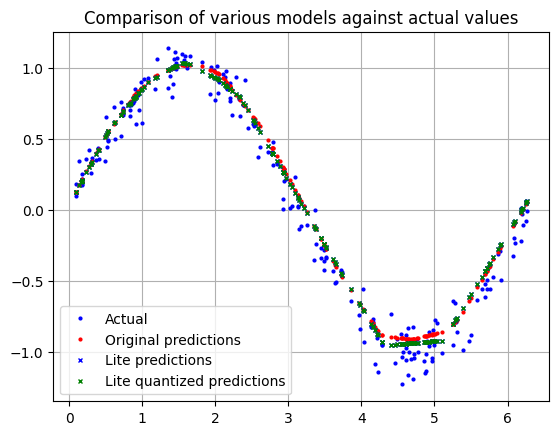

In [ ]:
# 각 모델에 대한 인터프리터 인스턴스 생성.
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

# 각 모델에 대한 메모리 할당
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# 입력과 결과 텐서에 대한 인덱스 가져오기
sine_model_input = sine_model.tensor(sine_model.get_input_details()[0]["index"])
sine_model_output = sine_model.tensor(sine_model.get_output_details()[0]["index"])
sine_model_quantized_input = sine_model_quantized.tensor(sine_model_quantized.get_input_details()[0]["index"])
sine_model_quantized_output = sine_model_quantized.tensor(sine_model_quantized.get_output_details()[0]["index"])

# 결과를 저장하기 위한 배열 생성
sine_model_predictions = np.empty(x_test.size)
sine_model_quantized_predictions = np.empty(x_test.size)

# 각 값에 대해 각 모델의 인터프리터를 실행하고 결과를 배열에 저장
for i in range(x_test.size):
  sine_model_input().fill(x_test[i])
  sine_model.invoke()
  sine_model_predictions[i] = sine_model_output()[0]

  sine_model_quantized_input().fill(x_test[i])
  sine_model_quantized.invoke()
  sine_model_quantized_predictions[i] = sine_model_quantized_output()[0]

# 데이터가 어떻게 정렬되는지 확인
plt.clf()
plt.grid(True)
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual', markersize=2)
plt.plot(x_test, predictions, 'ro', label='Original predictions', markersize=2)
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions', markersize=3)
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions', markersize=3)
plt.legend()
plt.show()

그래프에서 원본 모델, 양자화 없이 변환된 모델, 양자화 적용 변환된 모델에 대한 예측이 거의 구별할 수 없을 정도로 차이가 없다. 양자화 적용 변환된 모델을 사용해도 큰 무리가 없다는 것을 알 수 있다.

아래 코드는 각 모델 크기가 얼마나 차이가 나는지 출력한다.

In [ ]:
import os
# 양자화 미적용 변환 모델 크기 얻기
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
# 양자화 적용 변환 모델 크기 얻기
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
# 양자화 적용 변환 모델 크기 출력
print("Quantized model is %d bytes" % quantized_model_size)
# 모델 크기의 차 출력
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 3192 bytes
Quantized model is 3196 bytes
Difference is -4 bytes


책에서는 양자화 적용 모델의 크기가 더 작았으나 직접해보니 조금 더 크게 나았다. 사용 환경에 대한 차이로 이해하고 넘어간다.

변환된 모델의 크기가 크기 않으므로 가중치 데이터의 크기가 전체 크기에 작은 부분을 차지하므로 양자화 적용이 크게 영향을 미치지 않는다.

복잡한 모델의 경우, 가중치 데이터가 전체 크기에 큰 부분을 차지하므로 양자화로 인한 공간 절약이 훨씬 높아져 최대 4배까지 모델 크기를 줄일 수 있다.

양자화 적용 모델은 원래 버전보다 실행 시간이 단축되므로 마이크로 컨트롤러에서는 중요한 부분이다.



# C 소스 파일 만들기

TensorFlow Lite Converter로 변환된 모델을 마이크로 컨트롤러에서 사용하려면 모델을 C 소스 파일로 변환해야 한다.

이를 위해 xxd라는 커맨드라인 유틸리티를 사용한다.

다음 코드는 양자화 적용 모델을 xxd로 실행한다.

In [ ]:
# xxd를 사용할 수 없을 경우, 설치한다.
!apt-get -qq install xxd

In [ ]:
# 파일을 C 소스파일로 저장
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc
# 소스파일을 출력
!cat sine_model_quantized.cc

unsigned char sine_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0x08, 0x07, 0x00, 0x00,
  0x18, 0x07, 0x00, 0x00, 0x28, 0x0c, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x34, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x

이 출력 값을 복사하여 소스 코드에 붙이거나 Colab에서 파일을 다운로드하여 사용한다.